### NLP CARES - Create Models to .pickle


---

**Librarys**

In [1]:
import pandas as pd
import re
import numpy as np
from numba import jit
import pickle

#NLP
from spacy.lang.es.stop_words import STOP_WORDS
import spacy
#The vocabulary in spanish
nlp = spacy.load('es_core_news_sm')
#Stop_Words
nlp.vocab["no"].is_stop = False
nlp.vocab["realizado"].is_stop = False
nlp.vocab["sin"].is_stop = False
nlp.vocab["tener"].is_stop = False
nlp.vocab["manifestó"].is_stop = False
nlp.vocab["existe"].is_stop = False
nlp.vocab["considera"].is_stop = False
nlp.vocab["estados"].is_stop = False

#Algoritms / Graphics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from yellowbrick.classifier import ClassificationReport, DiscriminationThreshold, ROCAUC, ConfusionMatrix
from sklearn.svm import SVC

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


---
**Import Dataset**

In [2]:
df_train = pd.read_hdf('../../data/data.h5', 'TRAIN')
df_test = pd.read_hdf('../../data/test.h5', 'TEST')

In [3]:
print(df_train.shape,
     df_test.shape)

(26969, 10) (2881, 10)


In [4]:
df_train = df_train.drop([i for i in df_train.index if not df_train.loc[i, 'tokenized_sentences']])
df_test_main = df_test.drop([i for i in df_test.index if not df_test.loc[i, 'tokenized_sentences']])

In [5]:
W2Vmodel = pickle.load( open("../Final_Models/W2Vmodel.pickle", "rb"))

Split the dataset to train the model

In [6]:
def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    words = np.concatenate(sentence_group)  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

In [7]:
%%time
w2v_features = list(map(lambda sen_group: get_w2v_features(W2Vmodel, sen_group), df_train['tokenized_sentences']))
X_w2v = np.array(list(map(np.array, w2v_features)))
Z=pd.DataFrame(X_w2v)
main_train = pd.concat([Z, df_train], axis=1)

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


CPU times: user 20.6 s, sys: 102 ms, total: 20.7 s
Wall time: 20.7 s


### Est Ao

In [8]:
train = main_train.loc[main_train['est_Ao'].notnull(),]
train = train.reset_index(drop=True)

In [9]:
%%time

df_test = df_test_main.loc[df_test_main['est_Ao'].notnull(),]
df_test = df_test.reset_index(drop=True)


w2v_features_test = list(map(lambda sen_group: get_w2v_features(W2Vmodel, sen_group), df_test['tokenized_sentences']))
test_w2v = np.array(list(map(np.array, w2v_features_test)))
W=pd.DataFrame(test_w2v)
test = pd.concat([W, df_test], axis=1)

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


CPU times: user 3.02 s, sys: 27.9 ms, total: 3.05 s
Wall time: 2.5 s


In [10]:
X_train, X_test, y_train, y_test = train.iloc[:,0:200], test.iloc[:,0:200], train['est_Ao'], test['est_Ao']

In [11]:
%%time
clf = SVC(C=50, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0, decision_function_shape='ovr', 
          degree=3, gamma='scale', kernel='linear', max_iter=-1, probability=True, random_state=None, 
          shrinking=True, tol=0.001, verbose=False)
clf = clf.fit(X_train, y_train)

CPU times: user 10min 6s, sys: 163 ms, total: 10min 6s
Wall time: 10min 6s


In [12]:
pickle.dump(clf, open("../Final_Models/ML_model_est_Ao_SVM.pickle", "wb"))


In [13]:
with open('../Final_Models/ML_model_est_Ao_SVM.pickle', 'rb') as f:
    clf_est_Ao = pickle.load(f)

clf_est_Ao

SVC(C=50, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [14]:
# y_pred = clf_est_Ao.predict(X_test)
y_prob = clf_est_Ao.predict_proba(X_test)

print(roc_auc_score(y_test, y_prob[:,1]))

0.9301808035714285


/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


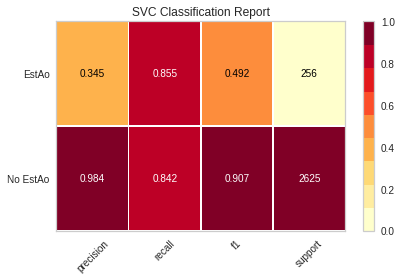

In [15]:
visualizer = ClassificationReport(clf_est_Ao, classes=['No EstAo', 'EstAo'], support=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


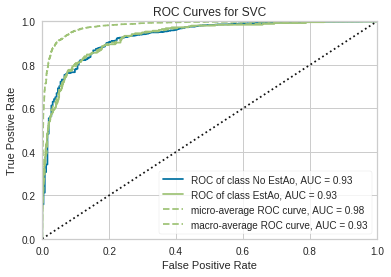

In [16]:
visualizer = ROCAUC(clf_est_Ao, classes=["No EstAo", "EstAo"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof();

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


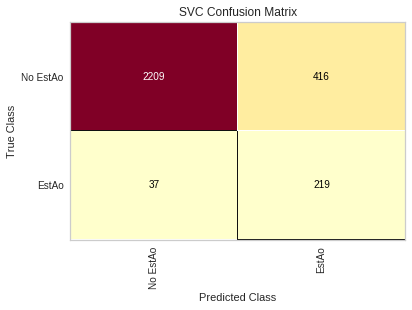

In [17]:
visualizer = ConfusionMatrix(clf_est_Ao, classes=['No EstAo', 'EstAo'], support=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

### Est Mv

In [18]:
train = main_train.loc[main_train['est_Mv'].notnull(),]
train = train.reset_index(drop=True)

In [19]:
%%time

df_test = df_test_main.loc[df_test_main['est_Mv'].notnull(),]
df_test = df_test.reset_index(drop=True)


w2v_features_test = list(map(lambda sen_group: get_w2v_features(W2Vmodel, sen_group), df_test['tokenized_sentences']))
test_w2v = np.array(list(map(np.array, w2v_features_test)))
W=pd.DataFrame(test_w2v)
test = pd.concat([W, df_test], axis=1)

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


CPU times: user 3.06 s, sys: 34.7 ms, total: 3.09 s
Wall time: 2.54 s


In [20]:
X_train, X_test, y_train, y_test = train.iloc[:,0:200], test.iloc[:,0:200], train['est_Mv'], test['est_Mv']

In [21]:
%%time
clf = SVC(C=50, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0, decision_function_shape='ovr', 
          degree=3, gamma='scale', kernel='linear', max_iter=-1, probability=True, random_state=None, 
          shrinking=True, tol=0.001, verbose=False)
clf = clf.fit(X_train, y_train)

CPU times: user 3min 16s, sys: 87.9 ms, total: 3min 16s
Wall time: 3min 16s


In [22]:
pickle.dump(clf, open("../Final_Models/ML_model_est_Mv_SVM.pickle", "wb"))


In [23]:
with open('../Final_Models/ML_model_est_Mv_SVM.pickle', 'rb') as f:
    clf_est_Mv = pickle.load(f)

clf_est_Mv

SVC(C=50, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [24]:
# y_pred = clf_est_Mv.predict(X_test)
y_prob = clf_est_Mv.predict_proba(X_test)

print(roc_auc_score(y_test, y_prob[:,1]))

0.9315829258133687


/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


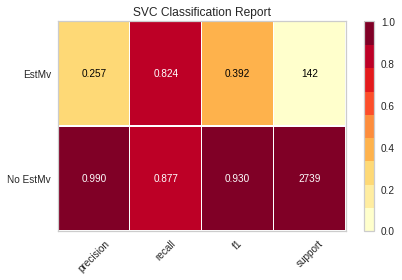

In [25]:
visualizer = ClassificationReport(clf_est_Mv, classes=['No EstMv', 'EstMv'], support=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


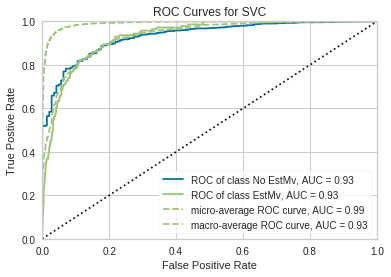

In [26]:
visualizer = ROCAUC(clf_est_Mv, classes=["No EstMv", "EstMv"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof();

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


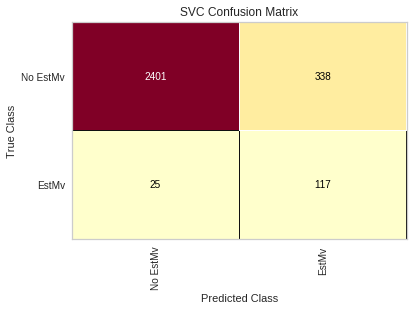

In [27]:
visualizer = ConfusionMatrix(clf_est_Mv, classes=['No EstMv', 'EstMv'], support=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

### Prot Ao

In [28]:
train = main_train.loc[main_train['prot_Ao'].notnull(),]
train = train.reset_index(drop=True)

In [29]:
%%time

df_test = df_test_main.loc[df_test_main['prot_Ao'].notnull(),]
df_test = df_test.reset_index(drop=True)


w2v_features_test = list(map(lambda sen_group: get_w2v_features(W2Vmodel, sen_group), df_test['tokenized_sentences']))
test_w2v = np.array(list(map(np.array, w2v_features_test)))
W=pd.DataFrame(test_w2v)
test = pd.concat([W, df_test], axis=1)

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


CPU times: user 3.01 s, sys: 40 ms, total: 3.05 s
Wall time: 2.51 s


In [30]:
X_train, X_test, y_train, y_test = train.iloc[:,0:200], test.iloc[:,0:200], train['prot_Ao'], test['prot_Ao']

In [31]:
%%time
clf = SVC(C=50, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0, decision_function_shape='ovr', 
          degree=3, gamma='scale', kernel='linear', max_iter=-1, probability=True, random_state=None, 
          shrinking=True, tol=0.001, verbose=False)
clf = clf.fit(X_train, y_train)

CPU times: user 8min 17s, sys: 67.9 ms, total: 8min 17s
Wall time: 8min 17s


In [32]:
pickle.dump(clf, open("../Final_Models/ML_model_prot_Ao_SVM.pickle", "wb"))


In [33]:
with open('../Final_Models/ML_model_prot_Ao_SVM.pickle', 'rb') as f:
    clf_prot_Ao = pickle.load(f)

clf_prot_Ao

SVC(C=50, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [34]:
# y_pred = clf_prot_Ao.predict(X_test)
y_prob = clf_prot_Ao.predict_proba(X_test)

print(roc_auc_score(y_test, y_prob[:,1]))

0.9800340284715284


/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


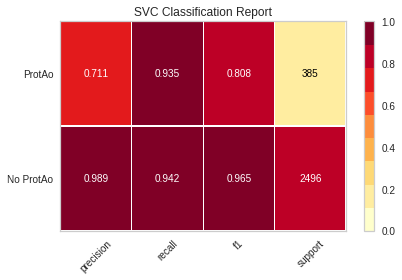

In [35]:
visualizer = ClassificationReport(clf_prot_Ao, classes=['No ProtAo', 'ProtAo'], support=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


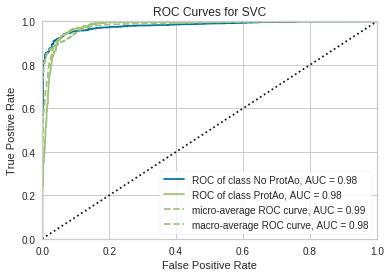

In [36]:
visualizer = ROCAUC(clf_prot_Ao, classes=["No ProtAo", "ProtAo"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof();

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


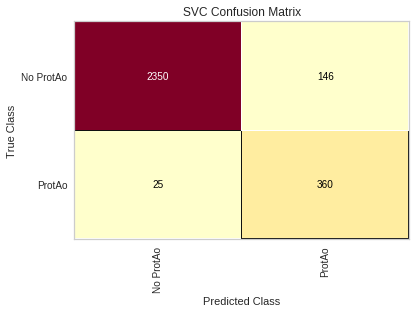

In [37]:
visualizer = ConfusionMatrix(clf_prot_Ao, classes=['No ProtAo', 'ProtAo'], support=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

### Prot Mv

In [38]:
train = main_train.loc[main_train['prot_Mv'].notnull(),]
train = train.reset_index(drop=True)

In [39]:
%%time

df_test = df_test_main.loc[df_test_main['prot_Mv'].notnull(),]
df_test = df_test.reset_index(drop=True)


w2v_features_test = list(map(lambda sen_group: get_w2v_features(W2Vmodel, sen_group), df_test['tokenized_sentences']))
test_w2v = np.array(list(map(np.array, w2v_features_test)))
W=pd.DataFrame(test_w2v)
test = pd.concat([W, df_test], axis=1)

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


CPU times: user 3.05 s, sys: 40 ms, total: 3.09 s
Wall time: 2.55 s


In [40]:
X_train, X_test, y_train, y_test = train.iloc[:,0:200], test.iloc[:,0:200], train['prot_Mv'], test['prot_Mv']

In [41]:
%%time
clf = SVC(C=50, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0, decision_function_shape='ovr', 
          degree=3, gamma='scale', kernel='linear', max_iter=-1, probability=True, random_state=None, 
          shrinking=True, tol=0.001, verbose=False)
clf = clf.fit(X_train, y_train)

CPU times: user 4min 44s, sys: 64 ms, total: 4min 44s
Wall time: 4min 44s


In [42]:
pickle.dump(clf, open("../Final_Models/ML_model_prot_Mv_SVM.pickle", "wb"))


In [43]:
with open('../Final_Models/ML_model_prot_Mv_SVM.pickle', 'rb') as f:
    clf_prot_Mv = pickle.load(f)

clf_prot_Mv

SVC(C=50, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [44]:
# y_pred = clf_est_Ao.predict(X_test)
y_prob = clf_prot_Mv.predict_proba(X_test)

print(roc_auc_score(y_test, y_prob[:,1]))

0.9562670288054561


/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


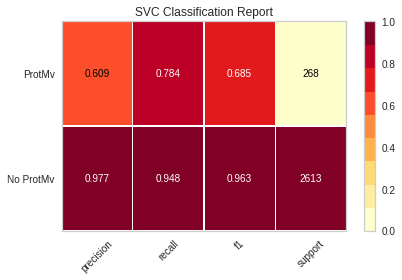

In [45]:
visualizer = ClassificationReport(clf_prot_Mv, classes=['No ProtMv', 'ProtMv'], support=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


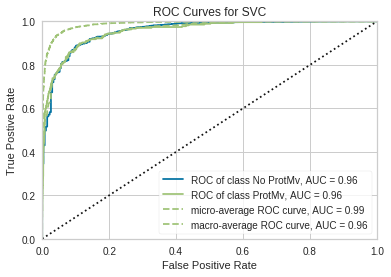

In [46]:
visualizer = ROCAUC(clf_prot_Mv, classes=["No ProtMv", "ProtMv"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof();

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


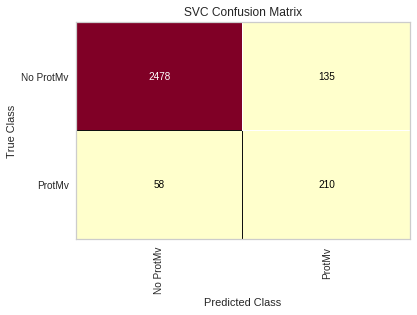

In [47]:
visualizer = ConfusionMatrix(clf_prot_Mv, classes=['No ProtMv', 'ProtMv'], support=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

### Insf Ao

In [48]:
train = main_train.loc[main_train['insf_Ao'].notnull(),]
train = train.reset_index(drop=True)

In [49]:
%%time

df_test = df_test_main.loc[df_test_main['insf_Ao'].notnull(),]
df_test = df_test.reset_index(drop=True)


w2v_features_test = list(map(lambda sen_group: get_w2v_features(W2Vmodel, sen_group), df_test['tokenized_sentences']))
test_w2v = np.array(list(map(np.array, w2v_features_test)))
W=pd.DataFrame(test_w2v)
test = pd.concat([W, df_test], axis=1)

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


CPU times: user 3.02 s, sys: 36 ms, total: 3.05 s
Wall time: 2.51 s


In [50]:
X_train, X_test, y_train, y_test = train.iloc[:,0:200], test.iloc[:,0:200], train['insf_Ao'], test['insf_Ao']

In [51]:
%%time
clf = SVC(C=50, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0, decision_function_shape='ovr', 
          degree=3, gamma='scale', kernel='linear', max_iter=-1, probability=True, random_state=None, 
          shrinking=True, tol=0.001, verbose=False)
clf = clf.fit(X_train, y_train)

CPU times: user 52min 29s, sys: 68 ms, total: 52min 29s
Wall time: 52min 28s


In [52]:
pickle.dump(clf, open("../Final_Models/ML_model_insf_Ao_SVM.pickle", "wb"))


In [53]:
with open('../Final_Models/ML_model_insf_Ao_SVM.pickle', 'rb') as f:
    clf_insf_Ao = pickle.load(f)

clf_insf_Ao

SVC(C=50, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [54]:
# y_pred = clf_est_Ao.predict(X_test)
y_prob = clf_insf_Ao.predict_proba(X_test)

print(roc_auc_score(y_test, y_prob[:,1]))

0.8665063015483343


/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


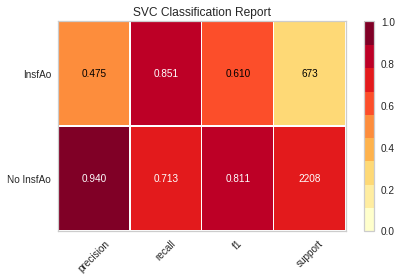

In [55]:
visualizer = ClassificationReport(clf_insf_Ao, classes=['No InsfAo', 'InsfAo'], support=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


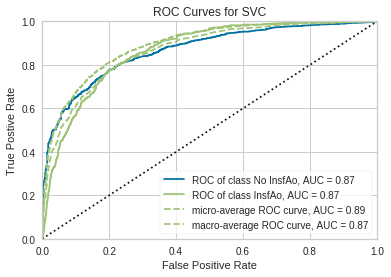

In [56]:
visualizer = ROCAUC(clf_insf_Ao, classes=["No InsfAo", "InsfAo"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof();

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


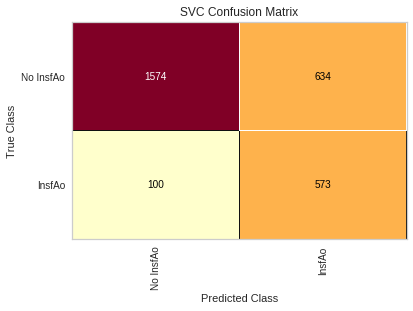

In [57]:
visualizer = ConfusionMatrix(clf_insf_Ao, classes=['No InsfAo', 'InsfAo'], support=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

### Insf Mv

In [58]:
train = main_train.loc[main_train['insf_Mv'].notnull(),]
train = train.reset_index(drop=True)

In [59]:
%%time

df_test = df_test_main.loc[df_test_main['insf_Mv'].notnull(),]
df_test = df_test.reset_index(drop=True)


w2v_features_test = list(map(lambda sen_group: get_w2v_features(W2Vmodel, sen_group), df_test['tokenized_sentences']))
test_w2v = np.array(list(map(np.array, w2v_features_test)))
W=pd.DataFrame(test_w2v)
test = pd.concat([W, df_test], axis=1)

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


CPU times: user 3.02 s, sys: 40 ms, total: 3.06 s
Wall time: 2.53 s


In [60]:
X_train, X_test, y_train, y_test = train.iloc[:,0:200], test.iloc[:,0:200], train['insf_Mv'], test['insf_Mv']

In [61]:
%%time
clf = SVC(C=50, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0, decision_function_shape='ovr', 
          degree=3, gamma='scale', kernel='linear', max_iter=-1, probability=True, random_state=None, 
          shrinking=True, tol=0.001, verbose=False)
clf = clf.fit(X_train, y_train)

CPU times: user 1h 14min 22s, sys: 63.9 ms, total: 1h 14min 22s
Wall time: 1h 14min 21s


In [62]:
pickle.dump(clf, open("../Final_Models/ML_model_insf_Mv_SVM.pickle", "wb"))


In [63]:
with open('../Final_Models/ML_model_insf_Mv_SVM.pickle', 'rb') as f:
    clf_insf_Mv = pickle.load(f)

clf_insf_Mv

SVC(C=50, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [64]:
# y_pred = clf_est_Ao.predict(X_test)
y_prob = clf_insf_Mv.predict_proba(X_test)

print(roc_auc_score(y_test, y_prob[:,1]))

0.8888216687992241


/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


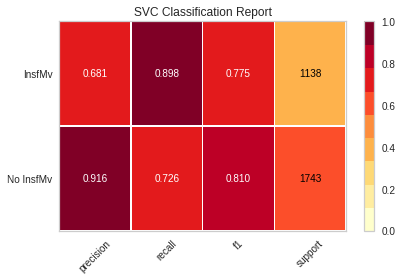

In [65]:
visualizer = ClassificationReport(clf_insf_Mv, classes=['No InsfMv', 'InsfMv'], support=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


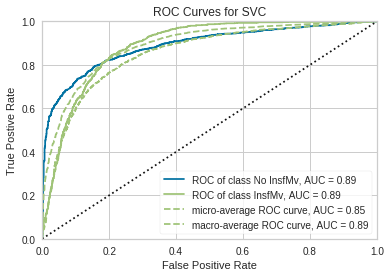

In [66]:
visualizer = ROCAUC(clf_insf_Mv, classes=["No InsfMv", "InsfMv"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof();

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


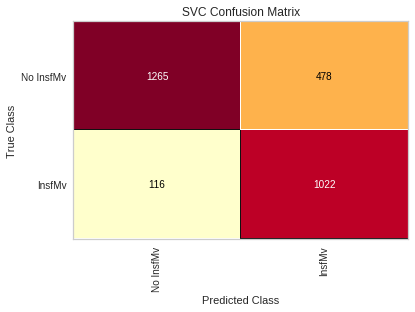

In [67]:
visualizer = ConfusionMatrix(clf_insf_Mv, classes=['No InsfMv', 'InsfMv'], support=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();